# Análisis predictivo del Alzheimer
Este proyecto tiene como objetivo desarrollar un modelo de aprendizaje automático capaz de predecir la probabilidad de que un paciente padezca Alzheimer, basándose en diversas características relacionadas con su estilo de vida, historial médico y factores genéticos.

**¿Porque es relevante este estudio ?**
El Alzheimer es una enfermedad neurodegenerativa que afecta a millones de personas. La detección temprana es clave para retrasar su progresión y mejorar la calidad de vida, pero sigue siendo un reto. Este estudio emplea aprendizaje automático para identificar patrones en datos de salud y predecir el riesgo de Alzheimer antes de que aparezcan síntomas, ayudando a los médicos en la toma de decisiones y estrategias preventivas.

**Modelos utilizados:**

|      Modelo                     | Precisión   |
|---------------------------------|-------------|
| RandomForest                    | 77%         |
| LogisticRegressio               | 72%         |
| XGBoost                         | 76%         |


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer,ConfusionMatrixDisplay, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


#from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
#pip install -U scikit-learn
#!pip install xgboost
# pip install category_encoders
##!pip install plotly
##pip install --upgrade imbalanced-learn



## 1. Obtención y exploración de Datos 

In [24]:
ruta = "Data/alzheimers_prediction_dataset.csv"
df = pd.read_csv(ruta,encoding='utf-8', sep=",")
df.head()

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

In [5]:
df.isnull().sum()

Country                                 0
Age                                     0
Gender                                  0
Education Level                         0
BMI                                     0
Physical Activity Level                 0
Smoking Status                          0
Alcohol Consumption                     0
Diabetes                                0
Hypertension                            0
Cholesterol Level                       0
Family History of Alzheimer’s           0
Cognitive Test Score                    0
Depression Level                        0
Sleep Quality                           0
Dietary Habits                          0
Air Pollution Exposure                  0
Employment Status                       0
Marital Status                          0
Genetic Risk Factor (APOE-ε4 allele)    0
Social Engagement Level                 0
Income Level                            0
Stress Levels                           0
Urban vs Rural Living             

In [ ]:
df.describe()

,Age,Education Level,BMI,Cognitive Test Score
count,74283.000000,74283.000000,74283.000000,74283.000000
mean,71.964703,9.487514,26.780639,64.654241
std,12.980748,5.757020,4.764679,20.153247
min,50.000000,0.000000,18.500000,30.000000
25%,61.000000,4.000000,22.700000,47.000000
50%,72.000000,9.000000,26.800000,65.000000
75%,83.000000,14.000000,30.900000,82.000000
max,94.000000,19.000000,35.000000,99.000000


In [ ]:
print(df['Alzheimer’s Diagnosis'].value_counts())


Alzheimer’s Diagnosis
No     43570
Yes    30713
Name: count, dtype: int64


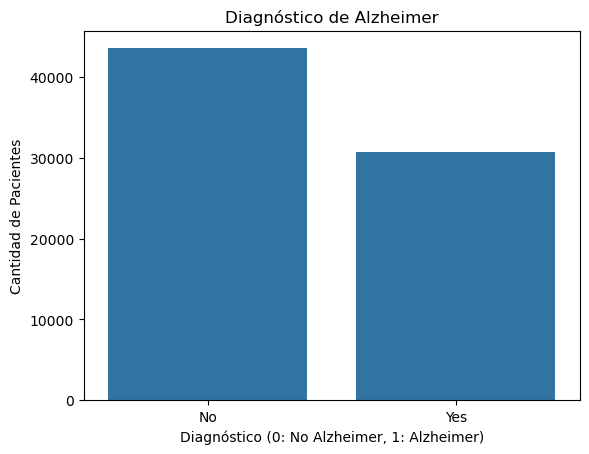

In [4]:
sns.countplot(x=df['Alzheimer’s Diagnosis'])
plt.title('Diagnóstico de Alzheimer')
plt.xlabel('Diagnóstico (0: No Alzheimer, 1: Alzheimer)')
plt.ylabel('Cantidad de Pacientes')
plt.show()

## 2. Limpieza y preprocesamiento
Nuestro dataset tiene tanto variables categóricas como variables numericas, debido a esto es necesario aplicar un preprocesamiento de la data

### 2.1 Conversión de variables categóricas

En este paso vamos a convertir esta variables categoricas a valores numerico que pueda entender la computadora. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

In [7]:

print(df.columns)

""" print("Country\n",df['Country'].unique())
print("\nEducation Level\n",df['Education Level'].unique())
print("\nPhysical Activity Level\n", df['Physical Activity Level'].unique())
print("\nSmoking Status\n", df['Smoking Status'].unique())
print("\nAlcohol Consumption\n", df['Alcohol Consumption'].unique())
print("\nDiabetes\n", df['Diabetes'].unique())
print("\nHypertension\n", df['Hypertension'].unique())
print("\nCholesterol Level\n", df['Cholesterol Level'].unique())
print("\nFamily History of Alzheimer’s\n", df['Family History of Alzheimer’s'].unique())
print("\nDepression Level\n", df['Depression Level'].unique())
print("\nSleep Quality\n", df['Sleep Quality'].unique())
print("\nDietary Habits\n", df['Dietary Habits'].unique())
print("\nAir Pollution Exposure\n", df['Air Pollution Exposure'].unique())
print("\nEmployment Status\n", df['Employment Status'].unique())
print("\nMarital Status\n", df['Marital Status'].unique())
print("\nGenetic Risk Factor (APOE-ε4 allele)\n", df['Genetic Risk Factor (APOE-ε4 allele)'].unique())
print("\nSocial Engagement Level\n", df['Social Engagement Level'].unique())
print("\nIncome Level\n", df['Income Level'].unique())
print("\nStress Levels\n", df['Stress Levels'].unique())
print("\nUrban vs Rural Living\n", df['Urban vs Rural Living'].unique())
 """

Index(['Country', 'Age', 'Gender', 'Education Level', 'BMI',
       'Physical Activity Level', 'Smoking Status', 'Alcohol Consumption',
       'Diabetes', 'Hypertension', 'Cholesterol Level',
       'Family History of Alzheimer’s', 'Cognitive Test Score',
       'Depression Level', 'Sleep Quality', 'Dietary Habits',
       'Air Pollution Exposure', 'Employment Status', 'Marital Status',
       'Genetic Risk Factor (APOE-ε4 allele)', 'Social Engagement Level',
       'Income Level', 'Stress Levels', 'Urban vs Rural Living',
       'Alzheimer’s Diagnosis'],
      dtype='object')


' print("Country\n",df[\'Country\'].unique())\nprint("\nEducation Level\n",df[\'Education Level\'].unique())\nprint("\nPhysical Activity Level\n", df[\'Physical Activity Level\'].unique())\nprint("\nSmoking Status\n", df[\'Smoking Status\'].unique())\nprint("\nAlcohol Consumption\n", df[\'Alcohol Consumption\'].unique())\nprint("\nDiabetes\n", df[\'Diabetes\'].unique())\nprint("\nHypertension\n", df[\'Hypertension\'].unique())\nprint("\nCholesterol Level\n", df[\'Cholesterol Level\'].unique())\nprint("\nFamily History of Alzheimer’s\n", df[\'Family History of Alzheimer’s\'].unique())\nprint("\nDepression Level\n", df[\'Depression Level\'].unique())\nprint("\nSleep Quality\n", df[\'Sleep Quality\'].unique())\nprint("\nDietary Habits\n", df[\'Dietary Habits\'].unique())\nprint("\nAir Pollution Exposure\n", df[\'Air Pollution Exposure\'].unique())\nprint("\nEmployment Status\n", df[\'Employment Status\'].unique())\nprint("\nMarital Status\n", df[\'Marital Status\'].unique())\nprint("\nGen

In [25]:
#Variables categóricas Nominales (Sin orden específico)
#One-Hot Encoding: Para variables con pocas categorías

cols=['Gender','Diabetes','Hypertension','Employment Status','Marital Status','Urban vs Rural Living']
df = pd.get_dummies(df, columns=cols, drop_first=True)


# Variables categiricas Ordinales (Orden específico)
df['Cholesterol Level'] = df['Cholesterol Level'].map({'Normal': 0, 'High': 1})
df['Family History of Alzheimer’s'] = df['Family History of Alzheimer’s'].map({'No': 0, 'Yes': 1})
df['Genetic Risk Factor (APOE-ε4 allele)'] = df['Genetic Risk Factor (APOE-ε4 allele)'].map({'No': 0, 'Yes': 1})


df['Physical Activity Level'] = df['Physical Activity Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Smoking Status'] = df['Smoking Status'].map({'Never': 0, 'Former': 1, 'Current': 2})
df['Alcohol Consumption'] = df['Alcohol Consumption'].map({'Never': 0, 'Occasionally': 1, 'Regularly': 2})
df['Depression Level'] = df['Depression Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Sleep Quality'] = df['Sleep Quality'].map({'Poor': 0, 'Average': 1, 'Good': 2})
df['Dietary Habits'] = df['Dietary Habits'].map({'Unhealthy': 0, 'Average': 1, 'Healthy': 2})
df['Air Pollution Exposure'] = df['Air Pollution Exposure'].map({ 'Low':0 ,'Medium':1,'High':2})
df['Social Engagement Level'] = df['Social Engagement Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Stress Levels'] = df['Stress Levels'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Income Level'] = df['Income Level'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Clonaremos la data actual en otro espacio de memoría
df2 = df.copy(deep=1)

# Aplicar Target Encoding a 'Country' 
df['Alzheimer’s Diagnosis'] = df['Alzheimer’s Diagnosis'].map({'No': 0, 'Yes': 1}) #¡Target de la data!
target_enc = TargetEncoder()
df['Country'] = target_enc.fit_transform(df['Country'],df['Alzheimer’s Diagnosis'])

df.head()

,Country,Age,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Cholesterol Level,Family History of Alzheimer’s,Cognitive Test Score,...,Stress Levels,Alzheimer’s Diagnosis,Gender_Male,Diabetes_Yes,Hypertension_Yes,Employment Status_Retired,Employment Status_Unemployed,Marital Status_Single,Marital Status_Widowed,Urban vs Rural Living_Urban
0,0.399946,90,1,33.0,1,0,1,0,0,90,...,2,0,True,False,False,True,False,True,False,True
1,0.402037,72,7,29.9,1,1,0,0,0,65,...,2,0,True,False,False,False,True,False,True,True
2,0.495213,86,19,22.9,2,2,1,0,0,43,...,2,0,False,False,True,False,False,True,False,False
3,0.386414,53,17,31.2,0,0,2,0,0,81,...,0,0,True,True,False,True,False,True,False,False
4,0.342098,58,3,30.0,2,1,0,0,0,49,...,2,0,False,True,False,False,False,False,False,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  float64
 1   Age                                   74283 non-null  int64  
 2   Education Level                       74283 non-null  int64  
 3   BMI                                   74283 non-null  float64
 4   Physical Activity Level               74283 non-null  int64  
 5   Smoking Status                        74283 non-null  int64  
 6   Alcohol Consumption                   74283 non-null  int64  
 7   Cholesterol Level                     74283 non-null  int64  
 8   Family History of Alzheimer’s         74283 non-null  int64  
 9   Cognitive Test Score                  74283 non-null  int64  
 10  Depression Level                      74283 non-null  int64  
 11  Sleep Quality  

### 2.2. Normalización de variables numéricas

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
df_N = df.copy()


df_N[[	'Age','Education Level','BMI','Physical Activity Level','Smoking Status','Alcohol Consumption','Cognitive Test Score','Depression Level',
                 'Sleep Quality','Dietary Habits','Air Pollution Exposure','Social Engagement Level',
                 'Stress Levels','Income Level']] = scaler.fit_transform(df[['Age','Education Level','BMI','Physical Activity Level',
                 'Smoking Status','Alcohol Consumption','Cognitive Test Score','Depression Level','Sleep Quality',
                 'Dietary Habits','Air Pollution Exposure','Social Engagement Level','Stress Levels',
                 'Income Level']])



## 3. Análisis Exploratorio

### 3.1. Visualización de correlaciones

In [8]:
import plotly.express as px

fig = px.imshow(df_N.corr(), 
                text_auto=True, 
                color_continuous_scale = "tempo",  
                template='plotly_dark',
                title="Correlation Heatmap")
fig.update_layout(
    width=1260, 
    height=1260  
)
fig.show()

## 4. Entrenamiento del Modelo

In [ ]:
# Calcular porcentajes de cada clase
clase_counts = df['Alzheimer’s Diagnosis'].value_counts()
porcentaje = (clase_counts / clase_counts.sum()) * 100

print(f"Porcentaje de cada clase:\n{porcentaje}")

Porcentaje de cada clase:
Alzheimer’s Diagnosis
0    58.654066
1    41.345934
Name: count, dtype: float64


In [9]:
# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_N.drop('Alzheimer’s Diagnosis', axis=1))
y = df_N['Alzheimer’s Diagnosis']

# Manejo del desbalanceo de clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


print("\nDistribución de clases después de aplicar SMOTE:")
print(y_resampled.value_counts())


Distribución de clases después de aplicar SMOTE:
Alzheimer’s Diagnosis
0    43570
1    43570
Name: count, dtype: int64


### 4.1 Modelos supervisados 

C:\Users\Sheily\AppData\Local\Temp\ipykernel_9532\3210729923.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




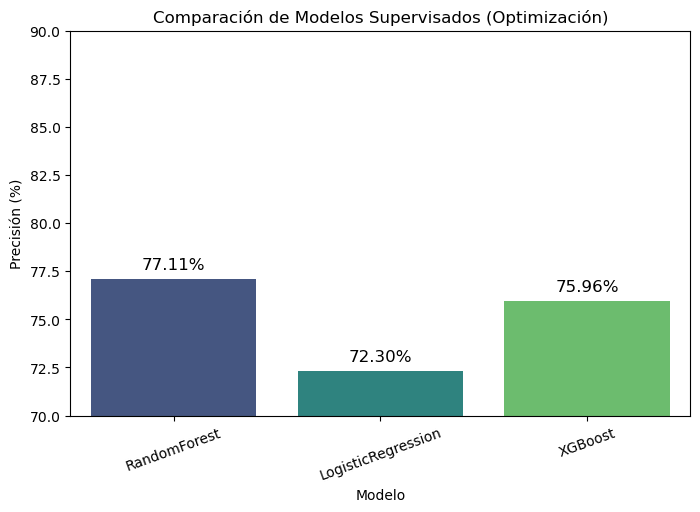

In [11]:
""" import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_Normalizado.drop('Alzheimer’s Diagnosis', axis=1))
y = df_Normalizado['Alzheimer’s Diagnosis']

# Manejo del desbalanceo de clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
 """
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Modelos con hiperparámetros ajustados
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=1200, max_depth=40, min_samples_split=2, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=2500, C=4.0, solver="liblinear", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=15, subsample=0.9,
        colsample_bytree=0.9, eval_metric="logloss", random_state=42
    )
}

# Entrenamiento y evaluación
scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    scores[name] = model.score(X_test, y_test) * 100

# Crear un DataFrame con los resultados
scores_df = pd.DataFrame(list(scores.items()), columns=["Modelo", "Precisión"])

# Configurar la gráfica
plt.figure(figsize=(8, 5))
sns.barplot(x="Modelo", y="Precisión", data=scores_df, palette="viridis")



# Personalizar
plt.ylim(70, 90)  # Ajusta el rango si es necesario
plt.ylabel("Precisión (%)")
plt.title("Comparación de Modelos Supervisados (Optimización)")
plt.xticks(rotation=20)

# Mostrar los valores en las barras
for index, value in enumerate(scores_df["Precisión"]):
    plt.text(index, value + 0.5, f"{value:.2f}%", ha="center", fontsize=12)

plt.show()




### 4.2. Modelos no supervisados

Dado que el dataset que venimos trabajando cuenta con la columna de target, para los siguientes modelos dicha columna es eliminada

In [12]:
df2.head()

,Country,Age,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Cholesterol Level,Family History of Alzheimer’s,Cognitive Test Score,...,Stress Levels,Alzheimer’s Diagnosis,Gender_Male,Diabetes_Yes,Hypertension_Yes,Employment Status_Retired,Employment Status_Unemployed,Marital Status_Single,Marital Status_Widowed,Urban vs Rural Living_Urban
0,Spain,90,1,33.0,1,0,1,0,0,90,...,2,No,True,False,False,True,False,True,False,True
1,Argentina,72,7,29.9,1,1,0,0,0,65,...,2,No,True,False,False,False,True,False,True,True
2,South Africa,86,19,22.9,2,2,1,0,0,43,...,2,No,False,False,True,False,False,True,False,False
3,China,53,17,31.2,0,0,2,0,0,81,...,0,No,True,True,False,True,False,True,False,False
4,Sweden,58,3,30.0,2,1,0,0,0,49,...,2,No,False,True,False,False,False,False,False,False


In [ ]:
#Tratamiento del dataframe, se crean 2 clones de dicho df, ?df2' simplemente no incluye las columnas 'Country' 'Alzheimer’s Diagnosis', y en 'x_for_kmeans'
#se normalizan los valores
df2.drop(['Country', 'Alzheimer’s Diagnosis'], axis=1, inplace=True)
scaler = MinMaxScaler()
x_for_kmeans = scaler.fit_transform(df2)
x_for_kmeans

array([[0.90909091, 0.05263158, 0.87878788, ..., 1.        , 0.        ,
        1.        ],
       [0.5       , 0.36842105, 0.69090909, ..., 0.        , 1.        ,
        1.        ],
       [0.81818182, 1.        , 0.26666667, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.15909091, 0.68421053, 0.58787879, ..., 1.        , 0.        ,
        0.        ],
       [0.52272727, 0.36842105, 0.63636364, ..., 0.        , 1.        ,
        0.        ],
       [0.15909091, 0.05263158, 0.8       , ..., 1.        , 0.        ,
        1.        ]])

In [17]:
# se aplica gridsearch para intentar mejorar la calidad del modelo

# def silhouette_scorer(estimator, X):
#     labels = estimator.fit_predict(X)
#     return silhouette_score(X, labels)

# param_grid = {
#     "init": ["random", "k-means++"],
#     "max_iter": [100, 300, 500],
#     "n_init": [10, 20, 30],
#     "algorithm": ["lloyd", "elkan"]
# }

# kmeans = KMeans(n_clusters=2, random_state=42)
# grid_search = GridSearchCV(kmeans, param_grid, scoring=make_scorer(silhouette_scorer), cv=3, verbose=1, n_jobs=-1)

# grid_search.fit(x_for_kmeans)


# print("Mejores parámetros:", grid_search.best_params_)
# print("Mejor Silhouette Score:", grid_search.best_score_)

In [ ]:
#instanciamiento de un modelo por cada dataframe, y respectivo ajuste a su data
kmeans = KMeans(n_clusters=2, algorithm='lloyd', init='random', max_iter=100, n_init=10, random_state=1)
kmeans.fit(df2)

kmeans_scaled = KMeans(n_clusters=2, algorithm='lloyd', init='random', max_iter=100, n_init=10, random_state=1)
kmeans_scaled.fit(x_for_kmeans)


KMeans(init='random', max_iter=100, n_clusters=2, n_init=10, random_state=1)

In [21]:
#recuento de valores por categoria
km = pd.Series(kmeans.labels_)
km_scaled = pd.Series(kmeans_scaled.labels_)
count_values = km.value_counts()
count_values2 = km_scaled.value_counts()
print('dataset original\n',df.value_counts(df['Alzheimer’s Diagnosis']), '\n\ncategorización por k-means (no escalado)\n',count_values, 
      '\n\ncategorización por k-means(escalado)\n', count_values2,)

dataset original
 Alzheimer’s Diagnosis
0    43570
1    30713
Name: count, dtype: int64 

categorización por k-means (no escalado)
 1    37200
0    37083
Name: count, dtype: int64 

categorización por k-means(escalado)
 0    49114
1    25169
Name: count, dtype: int64


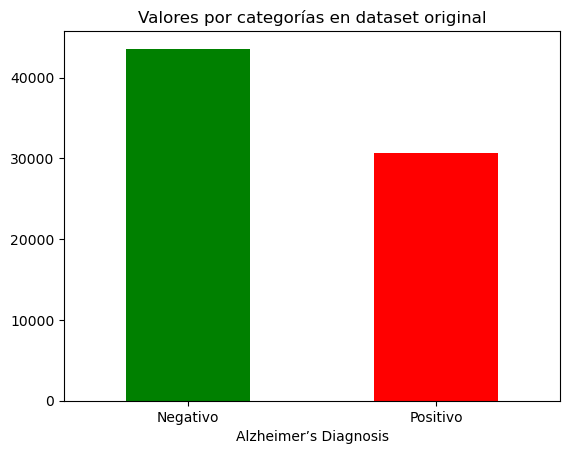

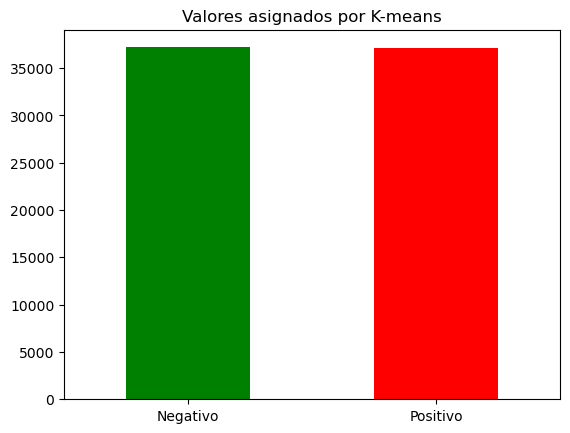

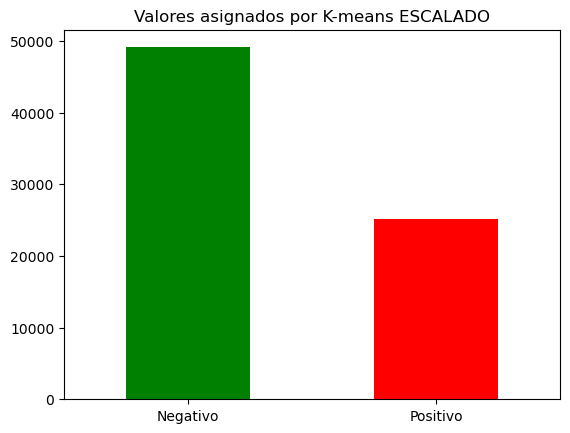

In [22]:
#grafica del recuento anterior
count_values_og = df.value_counts(df['Alzheimer’s Diagnosis'])
count_values_og.plot(kind='bar',color=['green','red' ], title='Valores por categorías en dataset original')
plt.xticks(ticks=[0, 1], labels=["Negativo", "Positivo"])
plt.xticks(rotation=0)
plt.show()

count_values.plot(kind='bar',color=['green','red' ], title='Valores asignados por K-means')
plt.xticks(ticks=[0, 1], labels=["Negativo", "Positivo"])
plt.xticks(rotation=0)
plt.show()

count_values2.plot(kind='bar',color=['green','red' ], title='Valores asignados por K-means ESCALADO')
plt.xticks(ticks=[0, 1], labels=["Negativo", "Positivo"])
plt.xticks(rotation=0)





plt.show()

## 5. Optinización y comparación de modelos 

### 5.1. Matriz de confusión Modelos Supervisados

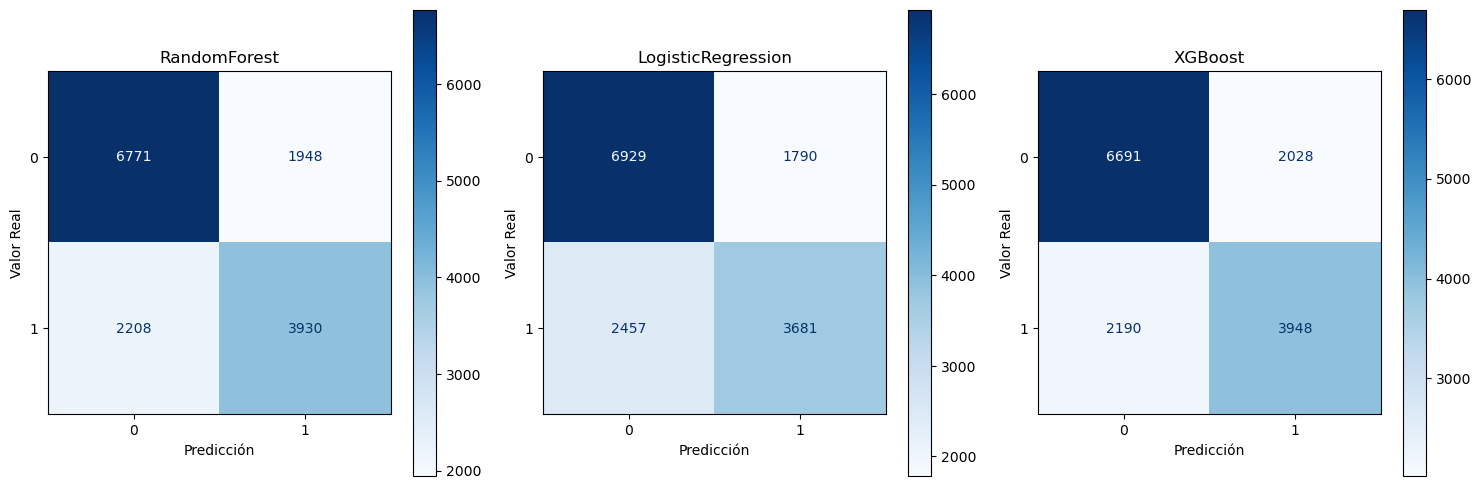

In [ ]:
fig, labels = plt.subplots(1, 3, figsize=(15, 5))

custom_cmap = plt.cm.Blues
for ax, (name, model) in zip(labels, models.items()):
    #X_train, X_test, y_train, y_test
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, cmap=custom_cmap)
    disp.ax_.set_title(name)
    disp.ax_.set_xlabel("Predicción")
    disp.ax_.set_ylabel("Valor Real")
plt.tight_layout()
plt.show()


In [ ]:
#Calculo de metricas

for name, model in models.items():
    y_pred = model.predict(x_test)
    print(f"Modelo: {name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

Modelo: RandomForest
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      8719
           1       0.67      0.64      0.65      6138

    accuracy                           0.72     14857
   macro avg       0.71      0.71      0.71     14857
weighted avg       0.72      0.72      0.72     14857

--------------------------------------------------
Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      8719
           1       0.67      0.60      0.63      6138

    accuracy                           0.71     14857
   macro avg       0.71      0.70      0.70     14857
weighted avg       0.71      0.71      0.71     14857

--------------------------------------------------
Modelo: XGBoost
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      8719
           1       0.66      0.64      0.65      6138

    accuracy    

### 5.2. Matriz de confusión modelos no supervisados

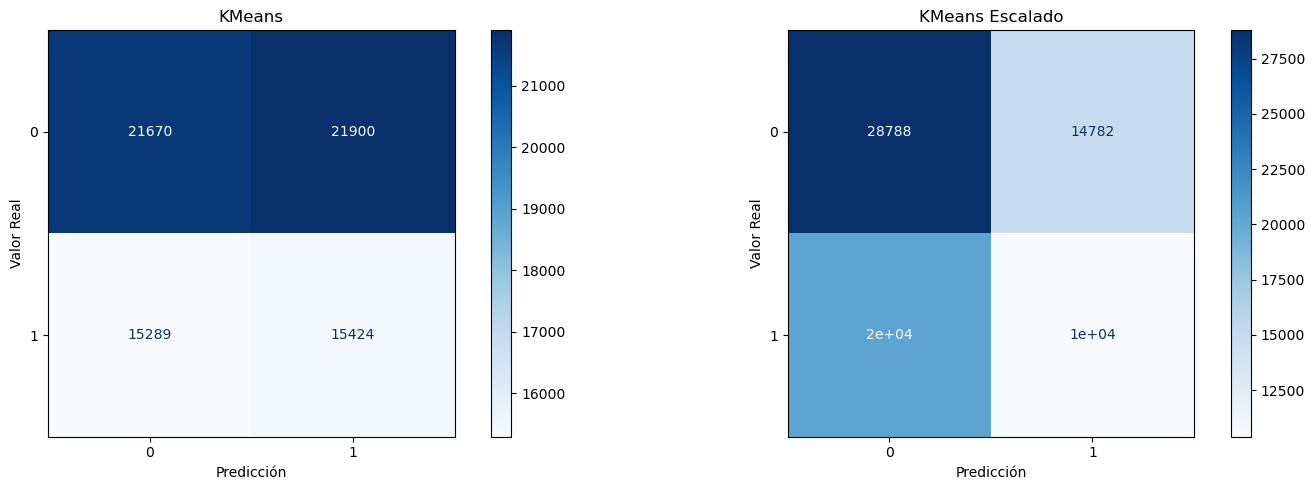

In [ ]:
fig, labels = plt.subplots(1, 2, figsize=(15, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(df['Alzheimer’s Diagnosis'], km), display_labels=["0", "1"])
disp.plot(ax=labels[0], cmap='Blues')
disp.ax_.set_title("KMeans")
disp.ax_.set_xlabel("Predicción")
disp.ax_.set_ylabel("Valor Real")

disp = ConfusionMatrixDisplay(confusion_matrix(df['Alzheimer’s Diagnosis'], km_scaled), display_labels=["0", "1"])
disp.plot(ax=labels[1], cmap='Blues')
disp.ax_.set_title("KMeans Escalado")
disp.ax_.set_xlabel("Predicción")
disp.ax_.set_ylabel("Valor Real")
plt.tight_layout()
plt.show()



In [25]:
#Calculo de metricas
print("KMeans")
print(classification_report(df['Alzheimer’s Diagnosis'], km))
print("-" * 50)
print("KMeans Escalado")
print(classification_report(df['Alzheimer’s Diagnosis'], km_scaled))
print("-" * 50)


KMeans
              precision    recall  f1-score   support

           0       0.59      0.50      0.54     43570
           1       0.41      0.50      0.45     30713

    accuracy                           0.50     74283
   macro avg       0.50      0.50      0.50     74283
weighted avg       0.51      0.50      0.50     74283

--------------------------------------------------
KMeans Escalado
              precision    recall  f1-score   support

           0       0.59      0.66      0.62     43570
           1       0.41      0.34      0.37     30713

    accuracy                           0.53     74283
   macro avg       0.50      0.50      0.50     74283
weighted avg       0.51      0.53      0.52     74283

--------------------------------------------------


## Exportación del modelo

In [ ]:
import joblib  

# Obtener el modelo RandomForest entrenado
rf_model = models["RandomForest"]

# Guardar el modelo en un archivo .pkl
joblib.dump(rf_model, "random_forest_model.pkl")

print("Modelo RandomForest exportado exitosamente.")
